Paul Scotti 2022

In [ ]:
# !wget -c https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/main/subj01_nsdgeneral.hdf5
!wget -c https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/main/stylegan_projections.hdf5
!wget -c https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/main/COCO_73k_subj_indices.hdf5

--2022-09-18 01:59:46--  https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/main/stylegan_projections.hdf5
Resolving huggingface.co (huggingface.co)... 52.202.207.64, 52.6.16.131, 2600:1f18:147f:e800:afa4:a769:1b42:e343, ...
Connecting to huggingface.co (huggingface.co)|52.202.207.64|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/8c/38/8c3895ae23f30bf32bd3c1662586cccb3697fa048ac15f740da784bb29651ff0/9e1271c9a89fc7e97f2c1c23d9c9fa6c1d199ba95c3e6799bdc41696e7193814?response-content-disposition=attachment%3B%20filename%3D%22stylegan_projections.hdf5%22 [following]
--2022-09-18 01:59:47--  https://cdn-lfs.huggingface.co/repos/8c/38/8c3895ae23f30bf32bd3c1662586cccb3697fa048ac15f740da784bb29651ff0/9e1271c9a89fc7e97f2c1c23d9c9fa6c1d199ba95c3e6799bdc41696e7193814?response-content-disposition=attachment%3B%20filename%3D%22stylegan_projections.hdf5%22
Resolving cdn-lfs.huggingface.co (cdn-lfs.huggingface.co)..

In [ ]:
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms
from tqdm import tqdm
import PIL
import h5py

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# import lpips
# loss_fn = lpips.LPIPS(net='vgg').to(device)

def np_to_Image(x):
    return PIL.Image.fromarray((x.transpose(1, 2, 0)*127.5+128).clip(0,255).astype('uint8'))
def torch_to_Image(x,device=device):
    if device=='cpu':
        return PIL.Image.fromarray((x.permute(0, 2, 3, 1)*127.5+128).clamp(0,255).to(torch.uint8).numpy()[0])
    else:
        return PIL.Image.fromarray((x.permute(0, 2, 3, 1)*127.5+128).clamp(0,255).to(torch.uint8).cpu().numpy()[0])
def Image_to_torch(x):
    return (transforms.ToTensor()(x[0])[:3].unsqueeze(0)-.5)/.5
def torch_to_matplotlib(x,device=device):
    if torch.mean(x)>10:
        x = (x.permute(0, 2, 3, 1)).clamp(0, 255).to(torch.uint8)
    else:
        x = (x.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    if device=='cpu':
        return x[0]
    else:
        return x.cpu().numpy()[0]

cuda


# Load Data

In [ ]:
# Load data
subj = 'subj01' # 37 sessions (each session = 750 images)
train_trials = np.arange(750*37 - 200)
val_trials = np.arange(750*37 - 200, 750*37)

f = h5py.File(f'{subj}_nsdgeneral.hdf5', 'r')
train_voxels = f['voxels'][train_trials]
val_voxels = f['voxels'][val_trials]
print("Voxels loaded.")

f = h5py.File('COCO_73k_subj_indices.hdf5', 'r')
all_73KID = f[subj]
train_ind = all_73KID[train_trials]
_, train_ind_order = np.unique(train_ind,return_inverse=True)
val_ind = all_73KID[val_trials]
_, val_ind_order = np.unique(val_ind,return_inverse=True)
print("Trial indices loaded.")

f = h5py.File('stylegan_projections.hdf5', 'r')
train_embs = f['projections'][np.unique(np.sort(train_ind))]
val_embs = f['projections'][np.unique(np.sort(val_ind))]
train_embs = train_embs[train_ind_order]
val_embs = val_embs[val_ind_order]
print("Embeddings loaded.")

# ensuring no validation trials w/ images presented in training data
exclude_repeats = ~np.isin(val_ind,train_ind)
val_voxels = val_voxels[exclude_repeats] 
val_embs = val_embs[exclude_repeats]

del all_73KID # no longer needed
f.close() # close the hdf5 file

print(train_voxels.shape, train_embs.shape)
print(val_voxels.shape, val_embs.shape)
assert len(train_voxels) == len(train_embs)
assert len(val_voxels) == len(val_embs)

Voxels loaded.
Trial indices loaded.
Embeddings loaded.
(27550, 15724) (27550, 32, 512)
(40, 15724) (40, 32, 512)


# Create / Train Model

In [ ]:
# set seeds to keep things reproducible and stay sane
torch.manual_seed(0)
np.random.seed(0)

# create network
input_size = 15724
h1 = 1024*3
voxels2emb = torch.nn.Sequential(
    torch.nn.BatchNorm1d(input_size),
    torch.nn.Linear(input_size, h1),
    torch.nn.GELU(),
    torch.nn.LayerNorm(h1),
    torch.nn.Linear(h1, h1),
    torch.nn.GELU(),
    torch.nn.LayerNorm(h1),
    torch.nn.Dropout(.15),  
    torch.nn.Linear(h1, h1),
    torch.nn.GELU(),
    torch.nn.LayerNorm(h1),
    torch.nn.Dropout(.15), 
    torch.nn.Linear(h1, h1),
    torch.nn.GELU(),
    torch.nn.Linear(h1, 512*32),
).to(device)

mse = nn.MSELoss()
initial_learning_rate = .003 
# optimizer = torch.optim.AdamW(voxels2emb.parameters(), lr=initial_learning_rate)
optimizer = torch.optim.SGD(voxels2emb.parameters(), lr=initial_learning_rate, momentum=0.95)
num_epochs = 50
batch_size = 32
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=3e-6, patience=5)

data_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(train_voxels.to(device), 
                                                                                 train_embs.to(device)),
                                                                    batch_size=batch_size, shuffle=True)
data_loader_val = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(val_voxels.to(device), 
                                                                                 val_embs.to(device)),
                                                                    batch_size=len(val_voxels), shuffle=False)

In [ ]:
train_losses = []; val_losses = [];
for epoch in tqdm(range(num_epochs)):
    voxels2emb.train()
    for i, (voxel, emb) in enumerate(data_loader):
        optimizer.zero_grad()
        
        emb_ = voxels2emb(voxel)
        emb_ = emb_.reshape(emb.shape)

        loss = mse(emb,emb_)

        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
    voxels2emb.eval() # note: each validation loss is entire set, not actually batched
    for i, (val_voxel, val_emb) in enumerate(data_loader_val):
        with torch.no_grad():
            val_emb_ = voxels2emb(val_voxel)
            val_emb_ = val_emb_.reshape(val_emb.shape)
            val_loss = mse(val_emb,val_emb_)
            val_losses.append(val_loss.item())
        
    # for ReduceLROnPlateau
    scheduler.step(val_loss)
    lrs.append(optimizer.param_groups[0]['lr'])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,3))
ax1.set_title(f"Training Loss\n(final loss={train_losses[-1]})")
ax1.plot(train_losses)
ax2.set_title(f"Validation Loss\n(final loss={val_losses[-1]})")
ax2.plot(val_losses)
ax3.set_title("Learning rate")
ax3.plot(lrs)
ax3.set_yscale('log')
plt.show()

# Save/Load Model

In [ ]:
# Saving
torch.save({
            'epoch': epoch,
            'model_state_dict': voxels2emb.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            }, 'voxels2emb.pth')

In [ ]:
# Loading 
checkpoint = torch.load('voxels2emb.pth')
voxels2emb.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']

# Visualize reconstructions
Note: you may need to restart kernel, load the model you saved in the above cell, and then run the following cells

In [ ]:
# Load StyleGAN-XL
!git clone https://github.com/autonomousvision/stylegan_xl
!wget https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet256.pkl

fatal: destination path 'stylegan_xl' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-08-19 14:03:51--  https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet256.pkl
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.170.109
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.170.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1962430448 (1.8G) [binary/octet-stream]
Saving to: ‘imagenet256.pkl.1’

imagenet256.pkl.1     4%[                    ]  93.10M  13.5MB/s    eta 2m 36s ^C


In [ ]:
sys.path.append('./stylegan_xl')
!pip install ninja
!pip install timm ftfy 
import dnnlib
import legacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Load pretrained model
network_pkl = 'imagenet256.pkl'
print('Loading networks from "%s"...' % network_pkl)
device = torch.device('cuda')
print('Using device:', device, file=sys.stderr)
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema']
    G = G.eval().requires_grad_(False).to(device)  

Loading networks from "imagenet256.pkl"...


Using device: cuda


In [ ]:
# Load original presented images 
f = h5py.File('subj01_nsdgeneral.hdf5', 'r')
# train_images = torch.Tensor(f['images'][train_trials]).permute(0,3,1,2)
val_images = torch.Tensor(f['images'][val_trials]).permute(0,3,1,2)
val_images = val_images[exclude_repeats]
f.close()

Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


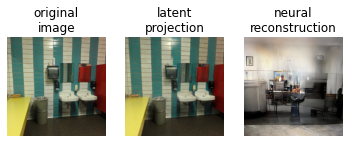

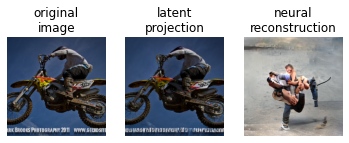

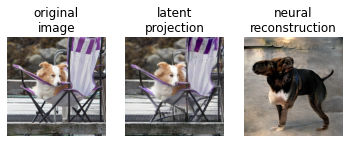

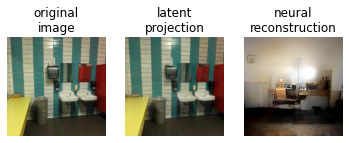

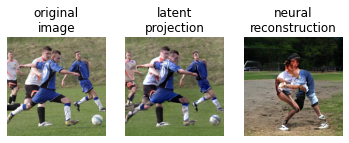

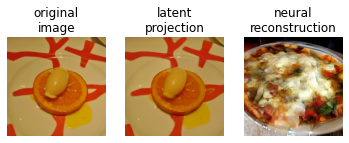

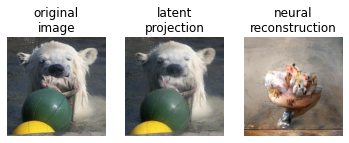

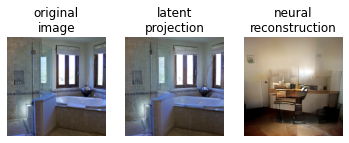

In [ ]:
# Depict original image / projection (i.e., best possible reconstruction) / reconstruction
voxels2emb.eval()
with torch.no_grad():
    emb_ = voxels2emb(val_voxels[:8].to(device)).reshape([8,32,512])
    
    for i in range(8):
        pic = G.synthesis(val_embs[i].unsqueeze(0).to(device), noise_mode='const')
        pic_ = G.synthesis(emb_[i].unsqueeze(0).to(device), noise_mode='const')
        
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(6,6))
        ax[0].imshow(torch_to_matplotlib(val_images[i].unsqueeze(0)))
        ax[1].imshow(torch_to_matplotlib(pic))
        ax[2].imshow(torch_to_matplotlib(pic_))
        ax[0].set_title("original\nimage")
        ax[0].axis("off")
        ax[1].set_title("latent\nprojection")
        ax[1].axis("off")
        ax[2].set_title("neural\nreconstruction")
        ax[2].axis("off")